In [1]:
print("Kernel alive and responding")


Kernel alive and responding


In [2]:
import sys
sys.executable


'C:\\Users\\jeead\\Downloads\\YKTmlL\\envs\\bert_resume\\python.exe'

In [3]:
import urllib.request
urllib.request.urlopen("https://huggingface.co").status


200

In [4]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"


In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-uncased",
    cache_dir="./hf_cache"
)


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jeead\hf_cache\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activa

In [8]:
type(tokenizer)


transformers.models.bert.tokenization_bert.BertTokenizer

In [9]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [10]:
df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")


In [11]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])


In [12]:
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)


In [13]:
len(train_df), len(val_df)


(12050, 1339)

In [14]:
train_dataset = Dataset.from_pandas(
    train_df[["Text", "label"]],
    preserve_index=False
)

val_dataset = Dataset.from_pandas(
    val_df[["Text", "label"]],
    preserve_index=False
)


In [15]:
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )


In [16]:
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)


Map: 100%|█████████████████████████████████████████████████████████████████| 1339/1339 [00:01<00:00, 717.06 examples/s]


In [17]:
tokenized_train.set_format("torch")
tokenized_val.set_format("torch")


In [18]:
len(tokenized_train[0]["input_ids"])


512

In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = len(label_encoder.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

model


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jeead\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                  

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device


device(type='cuda')

In [21]:
next(model.parameters()).device


device(type='cuda', index=0)

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_resume_results",
    eval_strategy="epoch",          # <-- FIXED
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


In [26]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


In [27]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)


In [28]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.980345,0.890212,0.849888


There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=1507, training_loss=1.8309481797348053, metrics={'train_runtime': 332.402, 'train_samples_per_second': 36.251, 'train_steps_per_second': 4.534, 'total_flos': 3171655344998400.0, 'train_loss': 1.8309481797348053, 'epoch': 1.0})

In [29]:
from transformers import TrainingArguments

training_args_2epoch = TrainingArguments(
    output_dir="./bert_resume_results_2epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,          # 👈 ONLY CHANGE
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


In [30]:
from transformers import Trainer

trainer_2epoch = Trainer(
    model=model,
    args=training_args_2epoch,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)


In [31]:
trainer_2epoch.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.528774,0.542223,0.883495
2,0.348223,0.495744,0.898432


There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=3014, training_loss=0.4847970872662601, metrics={'train_runtime': 661.0819, 'train_samples_per_second': 36.455, 'train_steps_per_second': 4.559, 'total_flos': 6343310689996800.0, 'train_loss': 0.4847970872662601, 'epoch': 2.0})

In [32]:
trainer_2epoch.save_model("./bert_resume_FINAL_2epoch")
tokenizer.save_pretrained("./bert_resume_FINAL_2epoch")


('./bert_resume_FINAL_2epoch\\tokenizer_config.json',
 './bert_resume_FINAL_2epoch\\tokenizer.json')

In [33]:
import json

with open("bert_resume_FINAL_2epoch/metrics.json", "w") as f:
    json.dump(trainer_2epoch.state.log_history, f, indent=2)


In [34]:
from transformers import TrainingArguments

training_args_accum = TrainingArguments(
    output_dir="./bert_resume_results_accum",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,   # 👈 KEY CHANGE
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


In [35]:
from transformers import Trainer

trainer_accum = Trainer(
    model=model,
    args=training_args_accum,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)


In [36]:
trainer_accum.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.552006,0.506275,0.907394
2,0.501172,0.494858,0.911875


There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=1508, training_loss=0.4847633882922266, metrics={'train_runtime': 615.1125, 'train_samples_per_second': 39.18, 'train_steps_per_second': 2.452, 'total_flos': 6343310689996800.0, 'train_loss': 0.4847633882922266, 'epoch': 2.0})

In [37]:
trainer_accum.save_model("./bert_resume_FINAL_accum")
tokenizer.save_pretrained("./bert_resume_FINAL_accum")


('./bert_resume_FINAL_accum\\tokenizer_config.json',
 './bert_resume_FINAL_accum\\tokenizer.json')

In [38]:
import json

with open("bert_resume_FINAL_accum/metrics.json", "w") as f:
    json.dump(trainer_accum.state.log_history, f, indent=2)


In [39]:
import json

with open("bert_resume_FINAL_accum/metrics.json", "w") as f:
    json.dump(trainer_accum.state.log_history, f, indent=2)


In [40]:
import numpy as np

pred_output = trainer_accum.predict(tokenized_val)

y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

len(y_true), len(y_pred)


(1339, 1339)

In [41]:
from sklearn.metrics import confusion_matrix

cm_bert = confusion_matrix(y_true, y_pred)
cm_bert.shape


(43, 43)

In [42]:
class_names = label_encoder.classes_
len(class_names)


43

In [1]:
import os
os.getcwd()


'C:\\Users\\jeead'

In [2]:
import os

os.listdir("C:\\Users\\jeead")


['.ai-navigator',
 '.anaconda',
 '.android',
 '.arduinoIDE',
 '.atom',
 '.cache',
 '.codex',
 '.conda',
 '.condarc',
 '.config',
 '.continuum',
 '.gitconfig',
 '.insomniac',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.mamba',
 '.node_repl_history',
 '.VirtualBox',
 '.vscode',
 '.wakatime',
 'ansel',
 'AppData',
 'Application Data',
 'bert_resume_FINAL_2epoch',
 'bert_resume_FINAL_accum',
 'bert_resume_results',
 'bert_resume_results_2epoch',
 'bert_resume_results_accum',
 'Contacts',
 'Cookies',
 'CrossDevice',
 'DAA LAb',
 'Documents',
 'Downloads',
 'dr_env',
 'edb_languagepack_3.exe',
 'edb_mtk.exe',
 'edb_npgsql.exe',
 'edb_pem_agent.exe',
 'edb_pem_agent.exe-20251226154103',
 'edb_pem_agent.exe-20251226200005',
 'edb_pem_agent.exe-20251226200022',
 'edb_pem_agent_8.exe',
 'edb_pem_server.exe',
 'edb_pem_server.exe-20251226154525',
 'edb_pem_server.exe-20251226200042',
 'edb_pem_server.exe-20251226200433',
 'edb_pem_server_8.exe',
 'edb_pgagent_pg15.exe',
 'edb_pgbouncer.ex

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_DIR = r"C:\Users\jeead\bert_resume_FINAL_accum"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model and tokenizer loaded from disk")


Loading weights: 100%|███████████████████████| 201/201 [00:00<00:00, 209.24it/s, Materializing param=classifier.weight]


Model and tokenizer loaded from disk


In [4]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Reload dataset
df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

# Encode labels (same as training)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])

# Same split as training (random_state is CRITICAL)
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

# Create validation dataset
val_dataset = Dataset.from_pandas(
    val_df[["Text", "label"]],
    preserve_index=False
)

print("Validation dataset recreated:", len(val_dataset))


Validation dataset recreated: 1339


In [5]:
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_val.set_format("torch")

print("Validation set tokenized:", len(tokenized_val))


Map: 100%|█████████████████████████████████████████████████████████████████| 1339/1339 [00:01<00:00, 690.65 examples/s]

Validation set tokenized: 1339


In [6]:
import torch

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(len(tokenized_val)):
        item = tokenized_val[i]
        input_ids = item["input_ids"].unsqueeze(0).to(device)
        attention_mask = item["attention_mask"].unsqueeze(0).to(device)
        label = item["label"].item()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pred = outputs.logits.argmax(dim=-1).item()

        all_preds.append(pred)
        all_labels.append(label)

print(len(all_preds), len(all_labels))


1339 1339


Matplotlib is building the font cache; this may take a moment.


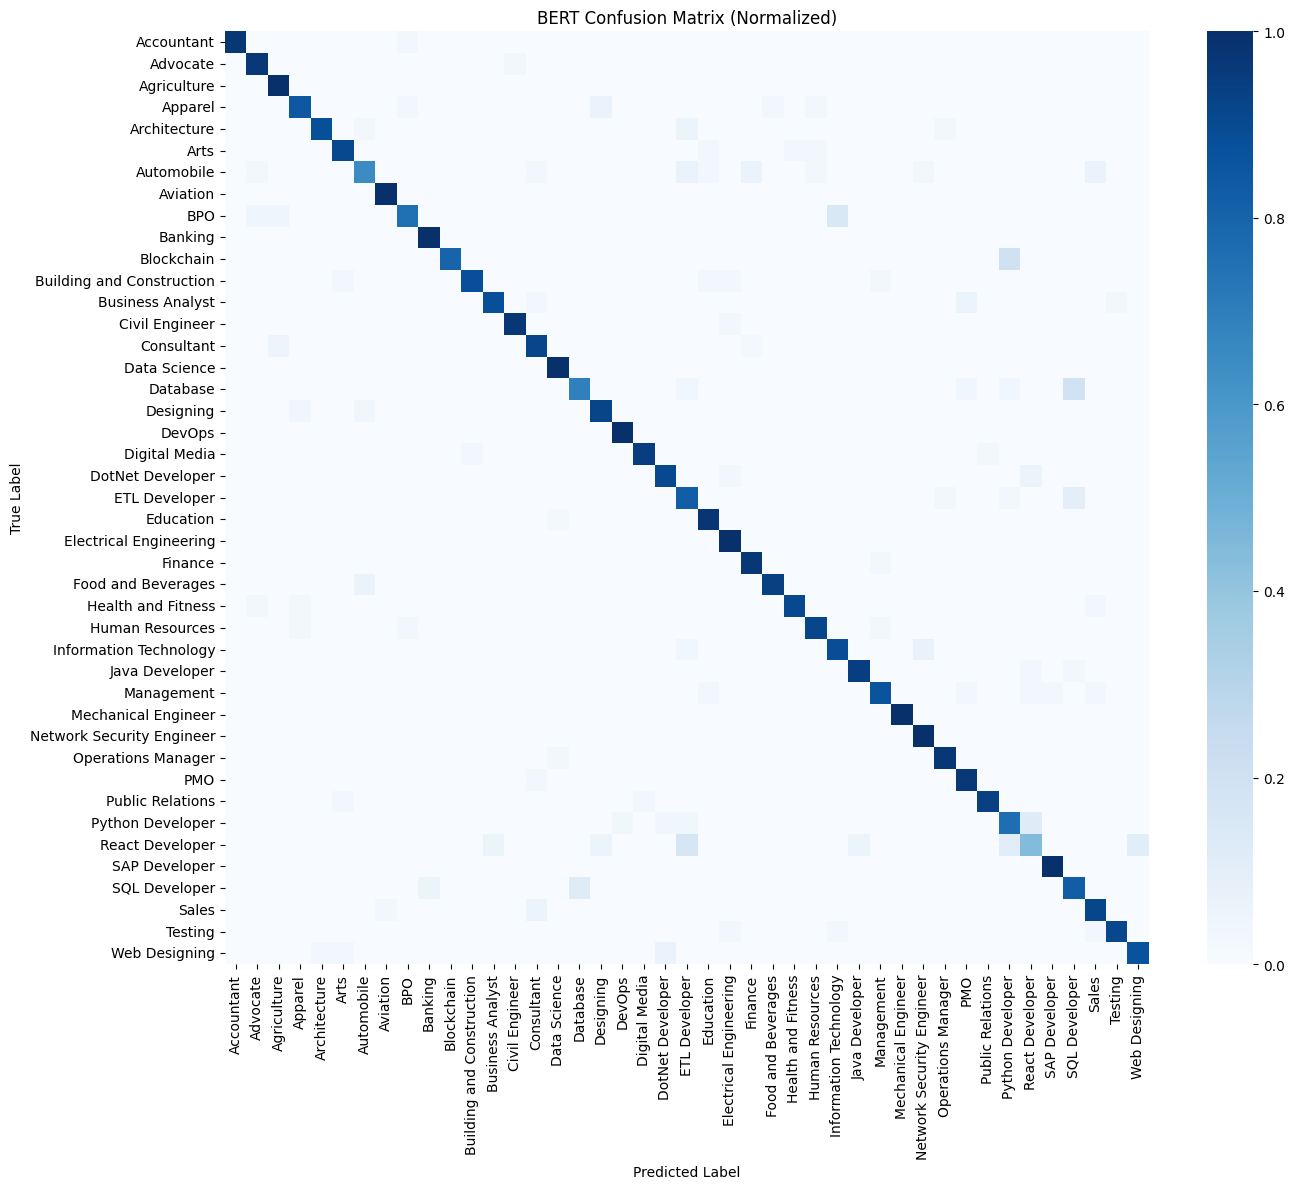

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Build confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize (row-wise)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# Class names
class_names = label_encoder.classes_

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
    cbar=True
)
plt.title("BERT Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# SAVE the image (this is important)
plt.savefig(
    r"C:\Users\jeead\bert_resume_FINAL_accum\confusion_matrix_bert.png",
    dpi=300
)

plt.show()


In [8]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    all_labels,
    all_preds,
    target_names=label_encoder.classes_,
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()

df_report.head()


,precision,recall,f1-score,support
Accountant,1.000000,0.971429,0.985507,35.0
Advocate,0.903226,0.965517,0.933333,29.0
Agriculture,0.906250,1.000000,0.950820,29.0
Apparel,0.900000,0.843750,0.870968,32.0
Architecture,0.967742,0.882353,0.923077,34.0


In [9]:
# Save per-class metrics to CSV
csv_path = r"C:\Users\jeead\bert_resume_FINAL_accum\bert_per_class_metrics.csv"
df_report.to_csv(csv_path)

csv_path


'C:\\Users\\jeead\\bert_resume_FINAL_accum\\bert_per_class_metrics.csv'

In [10]:
import shutil
import os

old_path = r"C:\Users\jeead\Untitled2.ipynb"
new_path = r"C:\Users\jeead\ResumeAtlas_BERT_Experiments.ipynb"

# Copy (acts as Save As)
shutil.copy(old_path, new_path)

print("Notebook saved as:", new_path)
print("File exists:", os.path.exists(new_path))


Notebook saved as: C:\Users\jeead\ResumeAtlas_BERT_Experiments.ipynb
File exists: True


In [11]:
backup_path = r"C:\Users\jeead\ResumeAtlas_BERT_Experiments_BACKUP.ipynb"

shutil.copy(new_path, backup_path)

print("Backup created at:", backup_path)
print("Backup exists:", os.path.exists(backup_path))


Backup created at: C:\Users\jeead\ResumeAtlas_BERT_Experiments_BACKUP.ipynb
Backup exists: True


In [13]:
from transformers import TrainingArguments

early_stop_args = TrainingArguments(
    output_dir="./bert_resume_earlystop",
    eval_strategy="epoch",          # <-- FIXED
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=5,             # max epochs (early stop decides)
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=100,
    report_to="none"
)

print("TrainingArguments ready")


TrainingArguments ready


In [14]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1   # stop if val accuracy doesn't improve for 1 epoch
)

print("EarlyStoppingCallback ready")


EarlyStoppingCallback ready


In [16]:
from datasets import Dataset

# Create training dataset
train_dataset = Dataset.from_pandas(
    train_df[["Text", "label"]],
    preserve_index=False
)

def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_train.set_format("torch")

print("Training set tokenized:", len(tokenized_train))


Map: 100%|███████████████████████████████████████████████████████████████| 12050/12050 [00:16<00:00, 744.28 examples/s]

Training set tokenized: 12050


In [18]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

print("compute_metrics ready")


compute_metrics ready


In [19]:
from transformers import Trainer

early_stop_trainer = Trainer(
    model=model,
    args=early_stop_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

print("Early-stop Trainer ready")


Early-stop Trainer ready


In [20]:
early_stop_trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.379152,0.534671,0.910381
2,0.557548,0.559073,0.905153


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.l

TrainOutput(global_step=1508, training_loss=0.3490073484830578, metrics={'train_runtime': 605.068, 'train_samples_per_second': 99.576, 'train_steps_per_second': 6.231, 'total_flos': 6343310689996800.0, 'train_loss': 0.3490073484830578, 'epoch': 2.0})

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])

train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

X_train = train_df["Text"]
y_train = train_df["label"]

X_val = val_df["Text"]
y_val = val_df["label"]

print(len(X_train), len(X_val))


12050 1339


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# TF-IDF vectorizer (standard, no tricks)
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Linear SVM
svm = LinearSVC()

svm.fit(X_train_tfidf, y_train)

val_preds_tfidf = svm.predict(X_val_tfidf)

print("TF-IDF + Linear SVM trained and predicted")


TF-IDF + Linear SVM trained and predicted


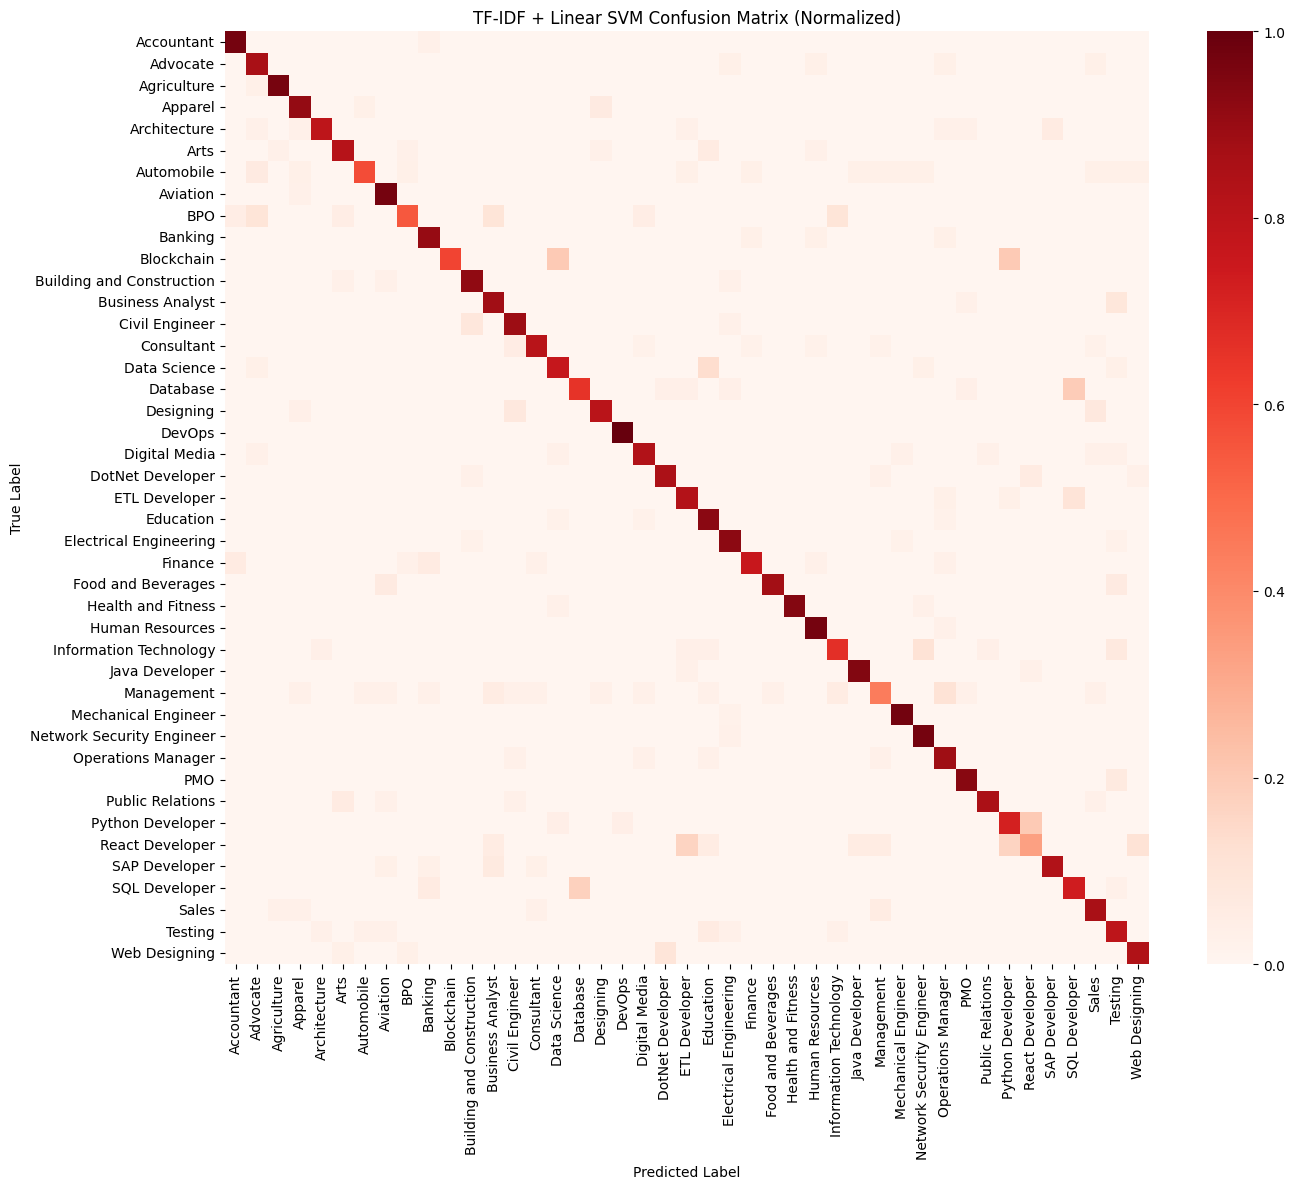

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Build confusion matrix
cm_tfidf = confusion_matrix(y_val, val_preds_tfidf)

# Normalize row-wise
cm_tfidf_norm = cm_tfidf.astype("float") / cm_tfidf.sum(axis=1, keepdims=True)

class_names = label_encoder.classes_

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_tfidf_norm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Reds",
    cbar=True
)
plt.title("TF-IDF + Linear SVM Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# SAVE the image
plt.savefig(
    r"C:\Users\jeead\bert_resume_FINAL_accum\confusion_matrix_tfidf.png",
    dpi=300
)

plt.show()


In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_DIR = r"C:\Users\jeead\bert_resume_FINAL_accum"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Final model loaded for inference")


Loading weights: 100%|███████████████████████| 201/201 [00:00<00:00, 244.00it/s, Materializing param=classifier.weight]


Final model loaded for inference


In [25]:
# Sample resume text (you can change this later)
sample_resume = """
Experienced data scientist with strong background in machine learning,
data analysis, and statistical modeling. Skilled in Python, Pandas,
NumPy, scikit-learn, TensorFlow, and SQL. Worked on predictive models,
classification problems, and data-driven decision making.
"""

# Tokenize
inputs = tokenizer(
    sample_resume,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move to GPU if available
inputs = {k: v.to(device) for k, v in inputs.items()}

print("Sample resume tokenized and ready")


Sample resume tokenized and ready


In [26]:
import torch
import torch.nn.functional as F

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)

# Get prediction
pred_id = torch.argmax(probs, dim=-1).item()
confidence = probs[0, pred_id].item()

predicted_label = label_encoder.inverse_transform([pred_id])[0]

print("Predicted Category:", predicted_label)
print("Confidence:", round(confidence * 100, 2), "%")


Predicted Category: Data Science
Confidence: 95.55 %


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

print("Total samples:", len(df))
df.head()


In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Category"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["Category"],
    random_state=42
)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


In [ ]:
label_encoder = LabelEncoder()

train_df["label"] = label_encoder.fit_transform(train_df["Category"])
val_df["label"] = label_encoder.transform(val_df["Category"])
test_df["label"] = label_encoder.transform(test_df["Category"])

num_labels = len(label_encoder.classes_)
print("Number of classes:", num_labels)


In [ ]:
train_dataset = Dataset.from_pandas(train_df[["Text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["Text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["Text", "label"]])


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )


In [1]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

print("Imports successful")


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful


In [2]:
df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

print("Total samples:", len(df))
df.head()


Total samples: 13389


,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


In [3]:
# First split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["Category"],
    random_state=42
)

# Second split: from the 30%, split into 10% val and 20% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=2/3,  # 20% overall
    stratify=temp_df["Category"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
print("Total check:", len(train_df) + len(val_df) + len(test_df))


Train size: 9372
Validation size: 1339
Test size: 2678
Total check: 13389


In [4]:
label_encoder = LabelEncoder()

train_df["label"] = label_encoder.fit_transform(train_df["Category"])
val_df["label"] = label_encoder.transform(val_df["Category"])
test_df["label"] = label_encoder.transform(test_df["Category"])

num_labels = len(label_encoder.classes_)

print("Number of classes:", num_labels)
print("Sample labels:", train_df[["Category", "label"]].head())


Number of classes: 43
Sample labels:                         Category  label
12171           Python Developer     36
11849                        PMO     34
7679   Building and Construction     11
2891                 Agriculture      2
10965                 Management     30


In [5]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df[["Text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["Text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["Text", "label"]])

print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))


Train dataset: 9372
Validation dataset: 1339
Test dataset: 2678


In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print("Tokenizer loaded successfully")


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jeead\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Tokenizer loaded successfully


In [7]:
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

print("Tokenization function ready")


Tokenization function ready


In [8]:
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

# Convert to PyTorch tensors
tokenized_train.set_format("torch")
tokenized_val.set_format("torch")
tokenized_test.set_format("torch")

print("Tokenization complete")
print("Train size:", len(tokenized_train))
print("Validation size:", len(tokenized_val))
print("Test size:", len(tokenized_test))



Map: 100%|█████████████████████████████████████████████████████████████████| 2678/2678 [00:02<00:00, 905.94 examples/s]

Tokenization complete
Train size: 9372
Validation size: 1339
Test size: 2678


In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on:", device)


Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 270.36it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

Model loaded on: cuda


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_70_10_20_run",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    report_to="none"
)

print("Training arguments ready")


Training arguments ready


In [12]:
print("Kernel working")



Kernel working


In [1]:
print("Ready")


Ready


In [1]:
print("Kernel working")

Kernel working


In [2]:
# ==============================
# BERT 70/10/20 TRAIN-VAL-TEST
# ==============================

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import matplotlib.pyplot as plt
import seaborn as sns

print("All imports successful")


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful


In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

print("Total samples:", len(df))
df.head()


Total samples: 13389


,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


In [4]:
# 70% Train, 30% Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["Category"],
    random_state=42
)

# From 30% → split into 10% Validation and 20% Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=2/3,  # Makes 20% overall
    stratify=temp_df["Category"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
print("Total check:", len(train_df) + len(val_df) + len(test_df))


Train size: 9372
Validation size: 1339
Test size: 2678
Total check: 13389


In [5]:
label_encoder = LabelEncoder()

train_df["label"] = label_encoder.fit_transform(train_df["Category"])
val_df["label"] = label_encoder.transform(val_df["Category"])
test_df["label"] = label_encoder.transform(test_df["Category"])

num_labels = len(label_encoder.classes_)

print("Number of classes:", num_labels)
print(train_df[["Category", "label"]].head())


Number of classes: 43
                        Category  label
12171           Python Developer     36
11849                        PMO     34
7679   Building and Construction     11
2891                 Agriculture      2
10965                 Management     30


In [6]:
train_dataset = Dataset.from_pandas(train_df[["Text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["Text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["Text", "label"]])

print("Train:", len(train_dataset))
print("Validation:", len(val_dataset))
print("Test:", len(test_dataset))


Train: 9372
Validation: 1339
Test: 2678


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print("Tokenizer loaded")


Tokenizer loaded


In [8]:
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

print("Tokenization function ready")


Tokenization function ready


In [9]:
def tokenize_function(examples):
    return tokenizer(
        examples["Text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

print("Tokenization function ready")


Tokenization function ready


In [10]:
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Text"]
)

tokenized_train.set_format("torch")
tokenized_val.set_format("torch")
tokenized_test.set_format("torch")

print("Tokenization complete")
print("Train:", len(tokenized_train))
print("Validation:", len(tokenized_val))
print("Test:", len(tokenized_test))


Map: 100%|█████████████████████████████████████████████████████████████████| 2678/2678 [00:02<00:00, 993.26 examples/s]

Tokenization complete
Train: 9372
Validation: 1339
Test: 2678


In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on:", device)


Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 299.27it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

Model loaded on: cuda


In [12]:
training_args = TrainingArguments(
    output_dir="./bert_70_10_20_run",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    report_to="none"
)

print("Training arguments ready")


Training arguments ready


In [13]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

print("Metric ready")


Metric ready


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

print("Trainer ready")


Trainer ready


In [15]:
trainer.train()


Step,Training Loss
100,7.598662
200,7.275259
300,6.620298
400,6.263760
500,5.889396
600,5.445302
700,4.970178
800,4.581764
900,4.401200
1000,4.185571


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


TrainOutput(global_step=1172, training_loss=5.466523909324672, metrics={'train_runtime': 502.267, 'train_samples_per_second': 37.319, 'train_steps_per_second': 2.333, 'total_flos': 4933569110925312.0, 'train_loss': 5.466523909324672, 'epoch': 2.0})

In [16]:
val_results = trainer.evaluate(tokenized_val)

print("Validation Accuracy:", val_results["eval_accuracy"])


Validation Accuracy: 0.5997012696041822


In [17]:
train_predictions = trainer.predict(tokenized_train)

train_preds = np.argmax(train_predictions.predictions, axis=-1)
train_acc = np.mean(train_preds == train_predictions.label_ids)

print("Training Accuracy:", train_acc)


Training Accuracy: 0.6167306871532223


In [18]:
next(model.parameters()).device


device(type='cuda', index=0)

In [19]:
print(tokenized_train.column_names)


['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [20]:
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])
tokenized_val = tokenized_val.remove_columns(["__index_level_0__"])
tokenized_test = tokenized_test.remove_columns(["__index_level_0__"])

print(tokenized_train.column_names)


['label', 'input_ids', 'token_type_ids', 'attention_mask']


In [21]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

model.to(device)

print("Fresh model loaded")


Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 245.71it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

Fresh model loaded


In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

print("Trainer recreated with clean datasets")


Trainer recreated with clean datasets


In [23]:
trainer.train()


Step,Training Loss
100,7.374912
200,6.089382
300,4.657751
400,3.717700
500,3.111722
600,2.646554
700,2.251812
800,1.939949
900,1.777956
1000,1.755876


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


TrainOutput(global_step=1172, training_loss=3.255253241737548, metrics={'train_runtime': 446.1073, 'train_samples_per_second': 42.017, 'train_steps_per_second': 2.627, 'total_flos': 4933569110925312.0, 'train_loss': 3.255253241737548, 'epoch': 2.0})

In [24]:
val_results = trainer.evaluate(tokenized_val)
print("Validation Accuracy:", val_results["eval_accuracy"])


Validation Accuracy: 0.8722927557879014


In [25]:
train_predictions = trainer.predict(tokenized_train)

train_preds = np.argmax(train_predictions.predictions, axis=-1)
train_acc = np.mean(train_preds == train_predictions.label_ids)

print("Training Accuracy:", train_acc)


Training Accuracy: 0.8982074263764405


In [26]:
test_predictions = trainer.predict(tokenized_test)

test_preds = np.argmax(test_predictions.predictions, axis=-1)
test_acc = np.mean(test_preds == test_predictions.label_ids)

print("Test Accuracy:", test_acc)


Test Accuracy: 0.871545929798357


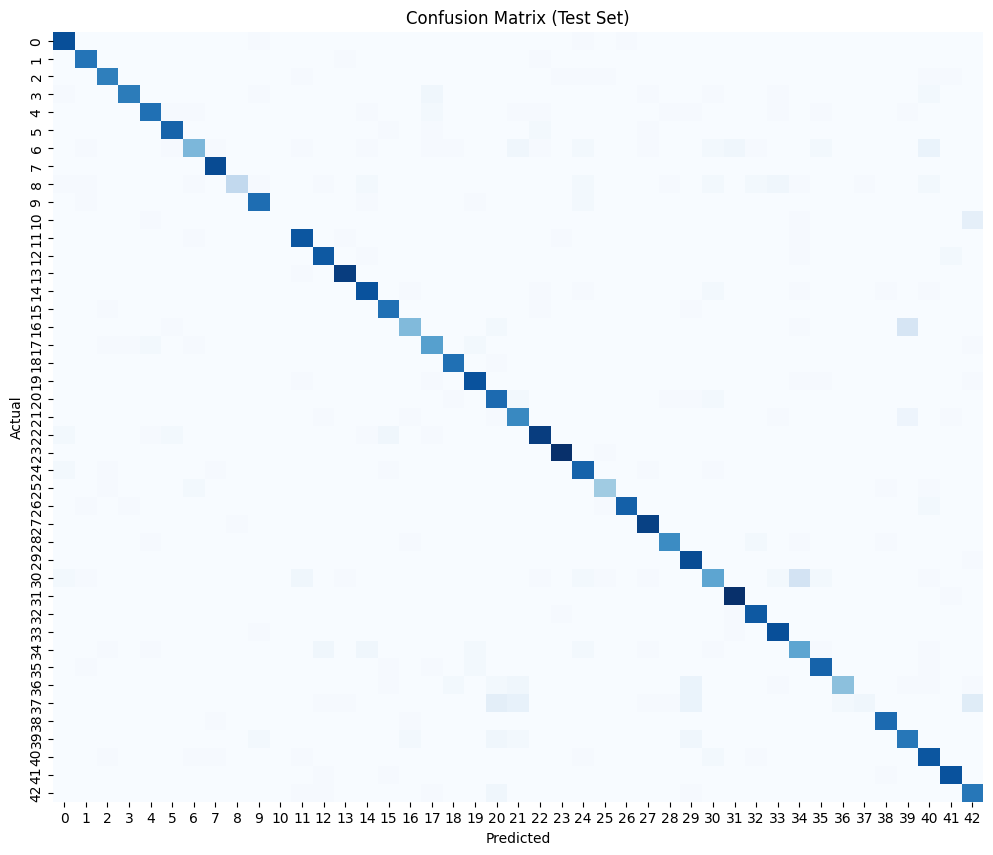

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        70
           1       0.90      0.97      0.93        58
           2       0.90      0.90      0.90        59
           3       0.96      0.84      0.90        64
           4       0.90      0.83      0.86        69
           5       0.92      0.92      0.92        66
           6       0.83      0.56      0.67        62
           7       0.94      1.00      0.97        68
           8       0.95      0.49      0.65        41
           9       0.91      0.92      0.91        63
          10       0.00      0.00      0.00         9
          11       0.88      0.94      0.91        69
          12       0.89      0.94      0.91        68
          13       0.95      0.99      0.97        73
          14       0.87      0.89      0.88        74
          15       0.88      0.95      0.91        60
          16       0.85      0.67      0.75    

C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_predictions.label_ids, test_preds)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report (Test Set):")
print(classification_report(test_predictions.label_ids, test_preds))


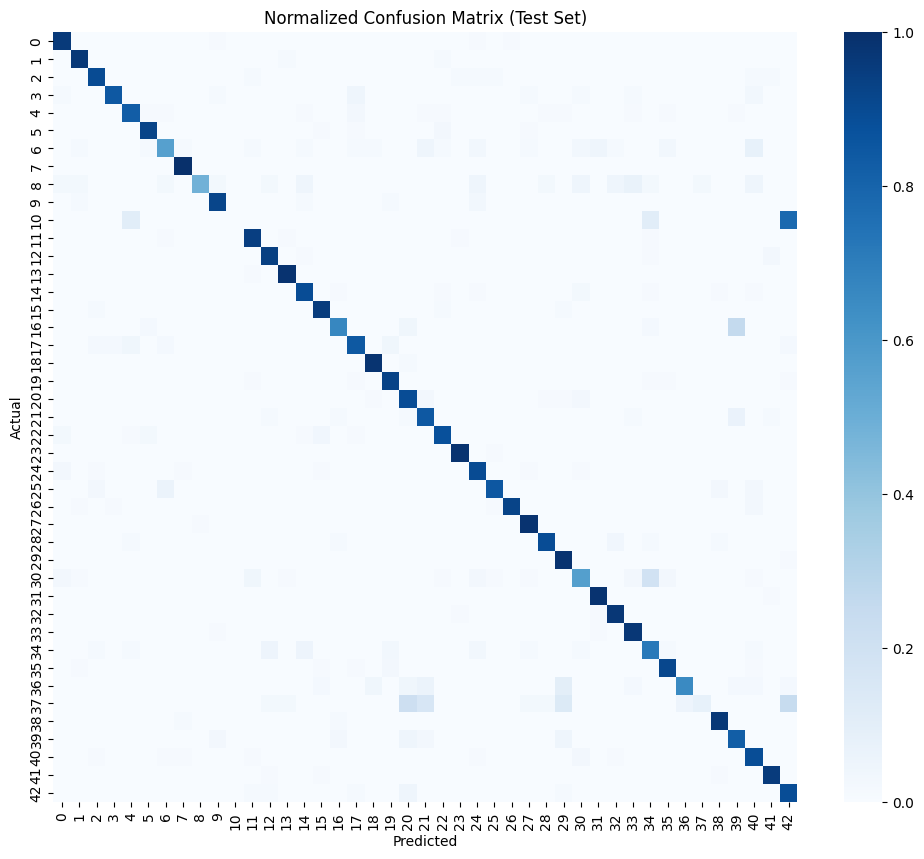

In [28]:
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,10))
sns.heatmap(cm_normalized, cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [31]:
print("Kernel working")

Kernel working


In [32]:
import transformers
print(transformers.__version__)


5.1.0


In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_resume_model",
    
    num_train_epochs=7,
    
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    
    gradient_accumulation_steps=2,
    
    learning_rate=2e-5,
    weight_decay=0.01,
    
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    
    eval_strategy="epoch",        # <-- changed
    save_strategy="epoch",
    
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    
    logging_steps=100,
    
    fp16=True,
    save_total_limit=2,
    
    report_to="none"
)


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [34]:
import math

train_batch_size = 8
grad_accum = 2
effective_batch_size = train_batch_size * grad_accum

steps_per_epoch = math.ceil(9372 / effective_batch_size)
total_steps = steps_per_epoch * 7
warmup_steps = int(0.1 * total_steps)

print("Steps per epoch:", steps_per_epoch)
print("Total steps:", total_steps)
print("Warmup steps:", warmup_steps)


Steps per epoch: 586
Total steps: 4102
Warmup steps: 410


In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_resume_model",
    
    num_train_epochs=7,
    
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    
    gradient_accumulation_steps=2,
    
    learning_rate=2e-5,
    weight_decay=0.01,
    
    warmup_steps=410,
    lr_scheduler_type="cosine",
    
    eval_strategy="epoch",
    save_strategy="epoch",
    
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    
    logging_steps=100,
    
    fp16=True,
    save_total_limit=2,
    
    report_to="none"
)


In [36]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [38]:
print(train_dataset[0])


{'Text': 'jeclaire claireica claire 100 montgomery clairet 10th floor 555 4321000 resumesampleexamplecom summary clairetructured python developer bringing 3 yearclaire comprehenclaireive experience developing backend componentclaire connecting applicationclaire web claireerviceclaire claireupporting frontend developerclaire techclaireavvy methodical profeclaireclaireional poclaireclaireeclaireclaireing clairetrong underclairetanding frontend technologieclaire familiar claireerverclaireide template languageclaire skills technical clairekillclaire languageclaire python java r c c toolclaire pycharm viclaireual clairetudio r clairetudio power bi tableau claireaclaire clairetudio gephi eclipclairee putty mainframeclaire excel jupyter notebook azure databrickclaire apache airflow operating claireyclairetem windowclaire unix linux databaclaireeclaire oracle myclaireql claireql noclaireql mongodb poclairetgreclaireql methodologieclaire waterfall agile cloud claireerviceclaire amazon web clair

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["Text"],
        truncation=True,
        padding="max_length",
        max_length=300   # IMPORTANT: paper used first 300 words
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map: 100%|█████████████████████████████████████████████████████████████████| 2678/2678 [00:03<00:00, 753.27 examples/s]


In [40]:
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")


In [41]:
print(train_dataset.column_names)


['Text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [42]:
cols_to_remove = ["Text", "__index_level_0__"]

train_dataset = train_dataset.remove_columns(cols_to_remove)
val_dataset = val_dataset.remove_columns(cols_to_remove)
test_dataset = test_dataset.remove_columns(cols_to_remove)


In [43]:
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")


In [44]:
print(train_dataset[0])


{'labels': tensor(36), 'input_ids': tensor([  101, 15333, 20464, 14737,  6249,  5555,  6249,  2531,  8482,  6249,
         2102,  6049,  2723, 29541,  4724, 17465,  8889,  2692, 13746, 21559,
        10814, 10288, 16613,  2571,  9006, 12654,  6249, 18300, 12165, 18750,
         9722,  5026,  1017,  2095, 20464, 14737,  4012, 28139, 10222, 20464,
        14737,  3512,  3325,  4975,  2067, 10497,  6922, 20464, 14737,  7176,
         4646, 20464, 14737,  4773,  6249,  2121,  7903,  8586, 19771,  2890,
         6249,  6279,  6442,  2075,  2392, 10497,  9722, 20464, 14737,  6627,
        20464, 14737, 11431, 10736,  4118,  7476, 11268,  8586, 19771,  2890,
        20464, 14737, 19301, 13433, 20464, 14737, 20464, 14737,  8586, 19771,
         2890, 20464, 14737,  2075,  6249, 15312,  2290,  2104, 20464, 14737,
         5794,  4667,  2392, 10497, 21416, 27095, 20464, 14737,  5220,  6249,
         2121,  6299, 20464, 14737,  5178, 23561,  2653, 20464, 14737,  4813,
         4087,  6249, 15872,

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [46]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,1.358473,0.674107,0.858103
2,1.052049,0.597179,0.859597
3,0.710097,0.539703,0.891710
4,0.643354,0.533280,0.890217
5,0.524662,0.549739,0.893951
6,0.388824,0.553697,0.891710
7,0.396113,0.557541,0.892457


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.l

TrainOutput(global_step=4102, training_loss=0.7188929504211329, metrics={'train_runtime': 1253.1729, 'train_samples_per_second': 52.35, 'train_steps_per_second': 3.273, 'total_flos': 1.01176710282648e+16, 'train_loss': 0.7188929504211329, 'epoch': 7.0})

In [48]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4060 Laptop GPU


In [49]:
print(next(model.parameters()).device)


cuda:0


In [50]:
print("Best model checkpoint:", trainer.state.best_model_checkpoint)
print("Best validation accuracy:", trainer.state.best_metric)


Best model checkpoint: ./bert_resume_model\checkpoint-2930
Best validation accuracy: 0.89395070948469


In [51]:
test_metrics = trainer.evaluate(test_dataset)
print(test_metrics)


{'eval_loss': 0.5631375908851624, 'eval_accuracy': 0.8917102315160568, 'eval_runtime': 9.7382, 'eval_samples_per_second': 275.0, 'eval_steps_per_second': 17.252, 'epoch': 7.0}


In [52]:
def tokenize_function(example):
    truncated_text = " ".join(example["Text"].split()[:300])
    return tokenizer(
        truncated_text,
        truncation=True,
        padding="max_length",
        max_length=512
    )


In [53]:
import os

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".csv"):
            print(os.path.join(root, file))


.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\mt19937-testset-1.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\mt19937-testset-2.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\pcg64-testset-1.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\pcg64-testset-2.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\pcg64dxsm-testset-1.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\pcg64dxsm-testset-2.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\philox-testset-1.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\philox-testset-2.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\sfc64-testset-1.csv
.\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\numpy\random\tests\data\sfc64-testset-2.

In [54]:
from datasets import load_dataset

dataset = load_dataset(
    "csv",
    data_files="C:/Users/jeead/Downloads/Preprocessed_Data.csv"
)

print(dataset)


Generating train split: 13389 examples [00:01, 9188.14 examples/s] 

DatasetDict({
    train: Dataset({
        features: ['Category', 'Text'],
        num_rows: 13389
    })
})


In [55]:
# Create label mapping
labels = sorted(list(set(dataset["train"]["Category"])))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

# Apply mapping
def encode_label(example):
    example["labels"] = label2id[example["Category"]]
    return example

dataset = dataset.map(encode_label)


Map: 100%|██████████████████████████████████████████████████████████████| 13389/13389 [00:01<00:00, 7360.13 examples/s]


In [56]:
print(dataset["train"][0])
print("Number of classes:", len(label2id))


{'Category': 'Accountant', 'Text': 'education omba executive leadership university texas 20162018 bachelor science accounting richland college 20052008 training certifications certified management accountant cma certified financial modeling valuation analyst compliance antimoney laundering 092016 american institute banking certified public account cpa lean six sigma green belt certified trade products financial regulations 082016 american institute banking achievements speaker bringing leader within 082019 successfully presented empowering speech leadership 500 participants speaker dallas convention cpas 032019 successfully delivered seminar 3k cpas convention guests teaching experience online teacher udemy 2017 taught online accounting nonaccountant course udemy similar online teaching platforms developed effective teaching modules materials curriculum target students took feedbacks students assist improving teaching methodology materials professional memberships affiliations american

In [58]:
from datasets import ClassLabel

# Create ClassLabel feature
class_label = ClassLabel(num_classes=len(label2id), names=labels)

dataset = dataset.cast_column("labels", class_label)

print(dataset["train"].features)


Casting the dataset: 100%|█████████████████████████████████████████████| 13389/13389 [00:00<00:00, 94737.64 examples/s]

{'Category': Value('string'), 'Text': Value('string'), 'labels': ClassLabel(names=['Accountant', 'Advocate', 'Agriculture', 'Apparel', 'Architecture', 'Arts', 'Automobile', 'Aviation', 'BPO', 'Banking', 'Blockchain', 'Building and Construction', 'Business Analyst', 'Civil Engineer', 'Consultant', 'Data Science', 'Database', 'Designing', 'DevOps', 'Digital Media', 'DotNet Developer', 'ETL Developer', 'Education', 'Electrical Engineering', 'Finance', 'Food and Beverages', 'Health and Fitness', 'Human Resources', 'Information Technology', 'Java Developer', 'Management', 'Mechanical Engineer', 'Network Security Engineer', 'Operations Manager', 'PMO', 'Public Relations', 'Python Developer', 'React Developer', 'SAP Developer', 'SQL Developer', 'Sales', 'Testing', 'Web Designing'])}


In [59]:
from datasets import DatasetDict

# 80/20 split
split_1 = dataset["train"].train_test_split(
    test_size=0.2,
    stratify_by_column="labels",
    seed=42
)

# Split 80% into 70/10
split_2 = split_1["train"].train_test_split(
    test_size=0.125,   # 10% of total
    stratify_by_column="labels",
    seed=42
)

final_dataset = DatasetDict({
    "train": split_2["train"],
    "validation": split_2["test"],
    "test": split_1["test"]
})

print(final_dataset)


DatasetDict({
    train: Dataset({
        features: ['Category', 'Text', 'labels'],
        num_rows: 9372
    })
    validation: Dataset({
        features: ['Category', 'Text', 'labels'],
        num_rows: 1339
    })
    test: Dataset({
        features: ['Category', 'Text', 'labels'],
        num_rows: 2678
    })
})


In [60]:
def truncate_to_300_words(example):
    example["Text"] = " ".join(example["Text"].split()[:300])
    return example

final_dataset = final_dataset.map(truncate_to_300_words)


Map: 100%|████████████████████████████████████████████████████████████████| 2678/2678 [00:00<00:00, 3071.73 examples/s]


In [61]:
print(len(final_dataset["train"][0]["Text"].split()))


300


In [62]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["Text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

final_dataset = final_dataset.map(tokenize_function, batched=True)


Map: 100%|█████████████████████████████████████████████████████████████████| 2678/2678 [00:02<00:00, 949.76 examples/s]


In [63]:
print(final_dataset["train"][0].keys())


dict_keys(['Category', 'Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])


In [64]:
cols_to_remove = ["Category", "Text"]

final_dataset = final_dataset.remove_columns(cols_to_remove)

print(final_dataset["train"][0].keys())


dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])


In [65]:
final_dataset.set_format("torch")


In [66]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=43,
    id2label=id2label,
    label2id=label2id
)


Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 253.40it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

In [67]:
trainer = Trainer(
    model=model,
    args=training_args,   # same as before (7 epochs, cosine, warmup=410)
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    compute_metrics=compute_metrics,
)


In [68]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,3.740505,1.268937,0.784167
2,1.440725,0.647544,0.874533
3,0.808441,0.595292,0.882748
4,0.679517,0.583779,0.887976
5,0.458917,0.629182,0.884989
6,0.330141,0.634451,0.886482
7,0.333267,0.631803,0.888723


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.l

TrainOutput(global_step=4102, training_loss=1.4202123697300413, metrics={'train_runtime': 1574.3341, 'train_samples_per_second': 41.671, 'train_steps_per_second': 2.606, 'total_flos': 1.7267491888238592e+16, 'train_loss': 1.4202123697300413, 'epoch': 7.0})

In [69]:
trainer.evaluate(final_dataset["test"])


{'eval_loss': 0.5295248627662659,
 'eval_accuracy': 0.8988050784167289,
 'eval_runtime': 16.4699,
 'eval_samples_per_second': 162.6,
 'eval_steps_per_second': 10.2,
 'epoch': 7.0}

In [71]:
training_args = TrainingArguments(
    output_dir="./bert_resume_model",

    num_train_epochs=7,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,

    gradient_accumulation_steps=4,   # <-- CHANGED (was 2)

    learning_rate=2e-5,
    weight_decay=0.01,

    warmup_steps=410,
    lr_scheduler_type="cosine",

    eval_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,

    logging_steps=100,

    fp16=True,
    save_total_limit=2,

    report_to="none"
)


In [72]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=43,
    id2label=id2label,
    label2id=label2id
)


Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 265.26it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

In [73]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    compute_metrics=compute_metrics,
)


In [74]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,14.468689,2.557956,0.563107
2,5.993965,0.973924,0.837192
3,2.674397,0.677088,0.864078
4,1.853349,0.586071,0.873786
5,1.309358,0.582642,0.876774
6,1.048666,0.570274,0.884989
7,1.017251,0.567869,0.886482


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.l

TrainOutput(global_step=2051, training_loss=4.085529202777894, metrics={'train_runtime': 1513.8567, 'train_samples_per_second': 43.336, 'train_steps_per_second': 1.355, 'total_flos': 1.7267491888238592e+16, 'train_loss': 4.085529202777894, 'epoch': 7.0})

In [75]:
trainer.evaluate(final_dataset["test"])


{'eval_loss': 0.5054879188537598,
 'eval_accuracy': 0.8879761015683346,
 'eval_runtime': 16.5328,
 'eval_samples_per_second': 161.981,
 'eval_steps_per_second': 10.162,
 'epoch': 7.0}

In [76]:
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    accuracy = (predictions == labels).mean()
    weighted_f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "weighted_f1": weighted_f1
    }


In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    compute_metrics=compute_metrics,   # IMPORTANT
)


In [78]:
trainer.evaluate(final_dataset["test"])


{'eval_loss': 0.5054879188537598,
 'eval_model_preparation_time': 0.0091,
 'eval_accuracy': 0.8879761015683346,
 'eval_weighted_f1': 0.8873796023370034,
 'eval_runtime': 16.4239,
 'eval_samples_per_second': 163.055,
 'eval_steps_per_second': 10.229}

In [81]:
train_metrics = trainer.evaluate(final_dataset["train"])
print(train_metrics)


{'eval_loss': 0.20014311373233795, 'eval_model_preparation_time': 0.0091, 'eval_accuracy': 0.9608408023900982, 'eval_weighted_f1': 0.9607255306058401, 'eval_runtime': 58.3008, 'eval_samples_per_second': 160.752, 'eval_steps_per_second': 10.051}


In [82]:
val_metrics = trainer.evaluate(final_dataset["validation"])
print(val_metrics)


{'eval_loss': 0.5678694248199463, 'eval_model_preparation_time': 0.0091, 'eval_accuracy': 0.8864824495892457, 'eval_weighted_f1': 0.8849143338910606, 'eval_runtime': 8.534, 'eval_samples_per_second': 156.901, 'eval_steps_per_second': 9.843}


In [83]:
test_metrics = trainer.evaluate(final_dataset["test"])
print(test_metrics)


{'eval_loss': 0.5054879188537598, 'eval_model_preparation_time': 0.0091, 'eval_accuracy': 0.8879761015683346, 'eval_weighted_f1': 0.8873796023370034, 'eval_runtime': 16.7094, 'eval_samples_per_second': 160.269, 'eval_steps_per_second': 10.054}


In [84]:
training_args = TrainingArguments(
    output_dir="./bert_resume_final",

    num_train_epochs=7,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,

    gradient_accumulation_steps=2,   # IMPORTANT

    learning_rate=2e-5,
    weight_decay=0.01,

    warmup_steps=410,
    lr_scheduler_type="cosine",

    eval_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,

    logging_steps=100,
    fp16=True,
    save_total_limit=2,
    report_to="none"
)


In [85]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=43,
    id2label=id2label,
    label2id=label2id
)


Loading weights: 100%|████████████████| 199/199 [00:00<00:00, 244.95it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initializ

In [86]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    compute_metrics=compute_metrics,
)


In [87]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Weighted F1
1,3.699566,1.269078,0.792382,0.771930
2,1.410113,0.651060,0.870052,0.867968
3,0.790793,0.583011,0.881255,0.879542
4,0.689895,0.576060,0.882748,0.882367
5,0.525140,0.605241,0.883495,0.882293
6,0.374791,0.619107,0.882001,0.880425
7,0.323314,0.622579,0.884989,0.883475


Writing model shards: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.l

TrainOutput(global_step=4102, training_loss=1.4245938278302397, metrics={'train_runtime': 1609.938, 'train_samples_per_second': 40.749, 'train_steps_per_second': 2.548, 'total_flos': 1.7267491888238592e+16, 'train_loss': 1.4245938278302397, 'epoch': 7.0})

In [88]:
train_metrics = trainer.evaluate(final_dataset["train"])
val_metrics = trainer.evaluate(final_dataset["validation"])
test_metrics = trainer.evaluate(final_dataset["test"])

print("TRAIN:", train_metrics)
print("VALIDATION:", val_metrics)
print("TEST:", test_metrics)


TRAIN: {'eval_loss': 0.14640401303768158, 'eval_accuracy': 0.9689500640204866, 'eval_weighted_f1': 0.9688602843851908, 'eval_runtime': 57.3684, 'eval_samples_per_second': 163.365, 'eval_steps_per_second': 10.215, 'epoch': 7.0}
VALIDATION: {'eval_loss': 0.622579038143158, 'eval_accuracy': 0.8849887976101568, 'eval_weighted_f1': 0.883474927585634, 'eval_runtime': 8.2525, 'eval_samples_per_second': 162.254, 'eval_steps_per_second': 10.179, 'epoch': 7.0}
TEST: {'eval_loss': 0.5327513813972473, 'eval_accuracy': 0.8943241224794622, 'eval_weighted_f1': 0.893142517483551, 'eval_runtime': 16.6576, 'eval_samples_per_second': 160.768, 'eval_steps_per_second': 10.086, 'epoch': 7.0}


In [89]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )

    return {
        "accuracy": accuracy,
        "weighted_precision": precision,
        "weighted_recall": recall,
        "weighted_f1": f1
    }


In [91]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    compute_metrics=compute_metrics
)


In [92]:
trainer.evaluate(final_dataset["test"])


{'eval_loss': 0.5327513813972473,
 'eval_model_preparation_time': 0.009,
 'eval_accuracy': 0.8943241224794622,
 'eval_weighted_precision': 0.8957699380112089,
 'eval_weighted_recall': 0.8943241224794622,
 'eval_weighted_f1': 0.893142517483551,
 'eval_runtime': 16.2721,
 'eval_samples_per_second': 164.577,
 'eval_steps_per_second': 10.324}

In [93]:
print("===== EXPERIMENT SUMMARY =====\n")

print("Dataset: ResumeAtlas")
print("Total Samples:", len(final_dataset["train"]) + len(final_dataset["validation"]) + len(final_dataset["test"]))
print("Number of Classes:", 43)

print("\nSplit:")
print("Train:", len(final_dataset["train"]))
print("Validation:", len(final_dataset["validation"]))
print("Test:", len(final_dataset["test"]))

print("\nModel: bert-base-uncased")
print("Epochs:", 7)
print("Batch Size:", 8)
print("Gradient Accumulation:", 2)
print("Effective Batch Size:", 8 * 2)
print("Scheduler: Cosine")
print("Warmup Steps:", 410)
print("FP16: Enabled")

print("\n===== FINAL METRICS =====\n")

print("TRAIN:")
print("Accuracy:", round(train_metrics["eval_accuracy"] * 100, 2), "%")
print("Weighted F1:", round(train_metrics["eval_weighted_f1"] * 100, 2), "%")
print("Loss:", round(train_metrics["eval_loss"], 4))

print("\nVALIDATION:")
print("Accuracy:", round(val_metrics["eval_accuracy"] * 100, 2), "%")
print("Weighted F1:", round(val_metrics["eval_weighted_f1"] * 100, 2), "%")
print("Loss:", round(val_metrics["eval_loss"], 4))

print("\nTEST:")
print("Accuracy:", round(test_metrics["eval_accuracy"] * 100, 2), "%")
print("Weighted Precision:", round(test_metrics["eval_weighted_precision"] * 100, 2), "%")
print("Weighted Recall:", round(test_metrics["eval_weighted_recall"] * 100, 2), "%")
print("Weighted F1:", round(test_metrics["eval_weighted_f1"] * 100, 2), "%")
print("Loss:", round(test_metrics["eval_loss"], 4))


===== EXPERIMENT SUMMARY =====

Dataset: ResumeAtlas
Total Samples: 13389
Number of Classes: 43

Split:
Train: 9372
Validation: 1339
Test: 2678

Model: bert-base-uncased
Epochs: 7
Batch Size: 8
Gradient Accumulation: 2
Effective Batch Size: 16
Scheduler: Cosine
Warmup Steps: 410
FP16: Enabled

===== FINAL METRICS =====

TRAIN:
Accuracy: 96.9 %
Weighted F1: 96.89 %
Loss: 0.1464

VALIDATION:
Accuracy: 88.5 %
Weighted F1: 88.35 %
Loss: 0.6226

TEST:
Accuracy: 89.43 %


KeyError: 'eval_weighted_precision'

In [94]:
test_metrics = trainer.evaluate(final_dataset["test"])
print(test_metrics)


{'eval_loss': 0.5327513813972473, 'eval_model_preparation_time': 0.009, 'eval_accuracy': 0.8943241224794622, 'eval_weighted_precision': 0.8957699380112089, 'eval_weighted_recall': 0.8943241224794622, 'eval_weighted_f1': 0.893142517483551, 'eval_runtime': 16.7105, 'eval_samples_per_second': 160.258, 'eval_steps_per_second': 10.054}


In [95]:
{'eval_loss': 0.5327513813972473, 'eval_model_preparation_time': 0.009, 'eval_accuracy': 0.8943241224794622, 'eval_weighted_precision': 0.8957699380112089, 'eval_weighted_recall': 0.8943241224794622, 'eval_weighted_f1': 0.893142517483551, 'eval_runtime': 16.7105, 'eval_samples_per_second': 160.258, 'eval_steps_per_second': 10.054}

{'eval_loss': 0.5327513813972473,
 'eval_model_preparation_time': 0.009,
 'eval_accuracy': 0.8943241224794622,
 'eval_weighted_precision': 0.8957699380112089,
 'eval_weighted_recall': 0.8943241224794622,
 'eval_weighted_f1': 0.893142517483551,
 'eval_runtime': 16.7105,
 'eval_samples_per_second': 160.258,
 'eval_steps_per_second': 10.054}

In [96]:
print("===== EXPERIMENT SUMMARY =====\n")

# Dataset Info
print("Dataset: ResumeAtlas")
print("Total Samples:", len(final_dataset["train"]) + len(final_dataset["validation"]) + len(final_dataset["test"]))
print("Number of Classes:", 43)

print("\nSplit (Stratified 70/10/20):")
print("Train:", len(final_dataset["train"]))
print("Validation:", len(final_dataset["validation"]))
print("Test:", len(final_dataset["test"]))

# Model & Training Setup
print("\nModel: bert-base-uncased")
print("Epochs:", 7)
print("Batch Size:", 8)
print("Gradient Accumulation:", 2)
print("Effective Batch Size:", 8 * 2)
print("Scheduler: Cosine")
print("Warmup Steps:", 410)
print("FP16: Enabled")

print("\n===== FINAL METRICS =====\n")

# Training Metrics
print("TRAIN:")
print("Accuracy:", round(train_metrics["eval_accuracy"] * 100, 2), "%")
print("Weighted F1:", round(train_metrics["eval_weighted_f1"] * 100, 2), "%")
print("Loss:", round(train_metrics["eval_loss"], 4))

# Validation Metrics
print("\nVALIDATION:")
print("Accuracy:", round(val_metrics["eval_accuracy"] * 100, 2), "%")
print("Weighted F1:", round(val_metrics["eval_weighted_f1"] * 100, 2), "%")
print("Loss:", round(val_metrics["eval_loss"], 4))

# Test Metrics
print("\nTEST:")
print("Accuracy:", round(test_metrics["eval_accuracy"] * 100, 2), "%")
print("Weighted Precision:", round(test_metrics["eval_weighted_precision"] * 100, 2), "%")
print("Weighted Recall:", round(test_metrics["eval_weighted_recall"] * 100, 2), "%")
print("Weighted F1:", round(test_metrics["eval_weighted_f1"] * 100, 2), "%")
print("Loss:", round(test_metrics["eval_loss"], 4))


===== EXPERIMENT SUMMARY =====

Dataset: ResumeAtlas
Total Samples: 13389
Number of Classes: 43

Split (Stratified 70/10/20):
Train: 9372
Validation: 1339
Test: 2678

Model: bert-base-uncased
Epochs: 7
Batch Size: 8
Gradient Accumulation: 2
Effective Batch Size: 16
Scheduler: Cosine
Warmup Steps: 410
FP16: Enabled

===== FINAL METRICS =====

TRAIN:
Accuracy: 96.9 %
Weighted F1: 96.89 %
Loss: 0.1464

VALIDATION:
Accuracy: 88.5 %
Weighted F1: 88.35 %
Loss: 0.6226

TEST:
Accuracy: 89.43 %
Weighted Precision: 89.58 %
Weighted Recall: 89.43 %
Weighted F1: 89.31 %
Loss: 0.5328


In [98]:
import pandas as pd

df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

print("Dataset loaded:", len(df))
df.head()


Dataset loaded: 13389


,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


In [99]:
from sklearn.model_selection import train_test_split

X = df["Text"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 10711
Test size: 2678


In [101]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:/Users/jeead/Downloads/Preprocessed_Data.csv")

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Dataset Shape: (13389, 2)
Columns: ['Category', 'Text']


,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


In [102]:
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Number of Classes:", df["Category"].nunique())


Dataset Shape: (13389, 2)
Columns: ['Category', 'Text']
Number of Classes: 43


In [103]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])

print("Encoded Classes:", len(le.classes_))
print(df[["Category", "label"]].head())


Encoded Classes: 43
     Category  label
0  Accountant      0
1  Accountant      0
2  Accountant      0
3  Accountant      0
4  Accountant      0


In [104]:
from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    df["Text"],
    df["label"],
    test_size=0.20,
    stratify=df["label"],
    random_state=42
)

# Second split: 70% train, 10% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,  # 0.125 of 80% ≈ 10% total
    stratify=y_temp,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 9372
Validation size: 1339
Test size: 2678


In [105]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize BoW vectorizer
bow_vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=20000
)

# Fit only on training data
X_train_bow = bow_vectorizer.fit_transform(X_train)

# Transform validation and test
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print("BoW Train Shape:", X_train_bow.shape)
print("BoW Validation Shape:", X_val_bow.shape)
print("BoW Test Shape:", X_test_bow.shape)


BoW Train Shape: (9372, 20000)
BoW Validation Shape: (1339, 20000)
BoW Test Shape: (2678, 20000)


In [106]:
from sklearn.svm import LinearSVC

# Initialize Linear SVM
svm_bow = LinearSVC(random_state=42)

# Train
svm_bow.fit(X_train_bow, y_train)

print("Model trained successfully.")


Model trained successfully.


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [107]:
svm_bow = LinearSVC(
    random_state=42,
    max_iter=10000
)

svm_bow.fit(X_train_bow, y_train)

print("Model retrained with increased iterations.")


Model retrained with increased iterations.


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [108]:
svm_bow = LinearSVC(
    random_state=42,
    max_iter=20000,
    tol=1e-3
)

svm_bow.fit(X_train_bow, y_train)

print("Model retrained with stable convergence settings.")


Model retrained with stable convergence settings.


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [109]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, X, y, split_name):
    y_pred = model.predict(X)
    
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="weighted"
    )
    
    print(f"\n=== {split_name} Metrics ===")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("Weighted Precision:", round(precision * 100, 2), "%")
    print("Weighted Recall:", round(recall * 100, 2), "%")
    print("Weighted F1:", round(f1 * 100, 2), "%")
    
    return acc, precision, recall, f1

# Evaluate
train_metrics_bow = evaluate_model(svm_bow, X_train_bow, y_train, "TRAIN")
val_metrics_bow = evaluate_model(svm_bow, X_val_bow, y_val, "VALIDATION")
test_metrics_bow = evaluate_model(svm_bow, X_test_bow, y_test, "TEST")



=== TRAIN Metrics ===
Accuracy: 98.78 %
Weighted Precision: 98.79 %
Weighted Recall: 98.78 %
Weighted F1: 98.78 %

=== VALIDATION Metrics ===
Accuracy: 78.79 %
Weighted Precision: 79.12 %
Weighted Recall: 78.79 %
Weighted F1: 78.67 %

=== TEST Metrics ===
Accuracy: 79.54 %
Weighted Precision: 79.52 %
Weighted Recall: 79.54 %
Weighted F1: 79.33 %


In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=20000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Validation Shape:", X_val_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)


TF-IDF Train Shape: (9372, 20000)
TF-IDF Validation Shape: (1339, 20000)
TF-IDF Test Shape: (2678, 20000)


In [111]:
svm_tfidf = LinearSVC(
    random_state=42,
    max_iter=20000,
    tol=1e-3
)

svm_tfidf.fit(X_train_tfidf, y_train)

print("TF-IDF + Linear SVM trained.")


TF-IDF + Linear SVM trained.


In [112]:
# Evaluate
train_metrics_tfidf = evaluate_model(svm_tfidf, X_train_tfidf, y_train, "TRAIN")
val_metrics_tfidf = evaluate_model(svm_tfidf, X_val_tfidf, y_val, "VALIDATION")
test_metrics_tfidf = evaluate_model(svm_tfidf, X_test_tfidf, y_test, "TEST")



=== TRAIN Metrics ===
Accuracy: 98.32 %
Weighted Precision: 98.33 %
Weighted Recall: 98.32 %
Weighted F1: 98.31 %

=== VALIDATION Metrics ===
Accuracy: 81.55 %
Weighted Precision: 81.56 %
Weighted Recall: 81.55 %
Weighted F1: 81.11 %

=== TEST Metrics ===
Accuracy: 82.19 %
Weighted Precision: 81.78 %
Weighted Recall: 82.19 %
Weighted F1: 81.68 %


In [113]:
import os

# Check current directory
print("Files in current directory:")
print(os.listdir())


Files in current directory:
['.ai-navigator', '.anaconda', '.android', '.arduinoIDE', '.atom', '.cache', '.codex', '.conda', '.condarc', '.config', '.continuum', '.gitconfig', '.insomniac', '.ipynb_checkpoints', '.ipython', '.jupyter', '.mamba', '.matplotlib', '.node_repl_history', '.VirtualBox', '.vscode', '.wakatime', 'anaconda_projects', 'ansel', 'AppData', 'Application Data', 'bert_70_10_20_run', 'bert_resume_earlystop', 'bert_resume_final', 'bert_resume_FINAL_2epoch', 'bert_resume_FINAL_accum', 'bert_resume_model', 'bert_resume_results', 'bert_resume_results_2epoch', 'bert_resume_results_accum', 'Contacts', 'Cookies', 'CrossDevice', 'DAA LAb', 'Documents', 'Downloads', 'dr_env', 'edb_languagepack_3.exe', 'edb_mtk.exe', 'edb_npgsql.exe', 'edb_pem_agent.exe', 'edb_pem_agent.exe-20251226154103', 'edb_pem_agent.exe-20251226200005', 'edb_pem_agent.exe-20251226200022', 'edb_pem_agent_8.exe', 'edb_pem_server.exe', 'edb_pem_server.exe-20251226154525', 'edb_pem_server.exe-20251226200042', 

In [114]:
print("\nFiles in Downloads:")
print(os.listdir("C:/Users/jeead/Downloads"))



Files in Downloads:
['!DOCTYPE html.html', '(Application LayerDNS) (s) (video).mkv', '0ffa49103ad801f255fcd16b78589bc6.jpg', '1. NOTES till switch case.pdf', '10. User Manual_Steps to Generate UGC Antiragging Undertaking.pdf', '10.3+Mondrian+Project.zip', '100.+Stack+Array.pdf', '101.+Stack+LL+C.pdf', '10th marksheet .pdf', '11. Medical Fitness Certificate.pdf', '11.0+Bootstrap+Intro.zip', '11.2+Bootstrap+Components.zip', '11.3+TinDog+Project.zip', '110.+InToPost.pdf', '12+Rules+to+Learn+to+Code+eBook-Copyright+App+Brewery.pdf', '12. Registration Form.pdf', '12th marksheet .pdf', '12_threads_concurrency.zip', '12_week_calisthenics_plan.csv', '13_async_python (1).zip', '13_async_python (2).zip', '13_async_python.zip', '14.+Storing+Items.pdf', '148.+What+are+Functions.pdf', '15.+Items+using+Vector.pdf', '15.+What+are+Variables.pdf', '150.+Positional+vs+Keyword+Arguments.pdf', '151.+Default+Arguments.pdf', '152.+Positional-Only+Arguments.pdf', '157.+FAQ+(Intro+to+OOPS+).pdf', '158.+FAQ+(

In [115]:
import os
print(os.path.exists("C:/Users/jeead/Downloads/glove.6B.100d.txt"))


False


In [116]:
import requests
import zipfile
import io
import os

# URL for GloVe
url = "https://nlp.stanford.edu/data/glove.6B.zip"

print("Downloading GloVe... (this may take 1–2 minutes)")

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Extract only 100d file
z.extract("glove.6B.100d.txt", path=".")

print("Download and extraction complete.")


Download and extraction complete.


In [117]:
print(os.path.exists("glove.6B.100d.txt"))


True


In [118]:
import numpy as np

embedding_dim = 100
glove_path = "glove.6B.100d.txt"

print("Loading GloVe embeddings...")

embeddings_index = {}

with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

print("Total words loaded:", len(embeddings_index))


Loading GloVe embeddings...
Total words loaded: 400000


In [119]:
def document_vector(text):
    words = text.split()
    word_vectors = [
        embeddings_index[word]
        for word in words
        if word in embeddings_index
    ]
    
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    
    return np.mean(word_vectors, axis=0)


print("Creating GloVe averaged embeddings...")

X_train_glove = np.array([document_vector(text) for text in X_train])
X_val_glove = np.array([document_vector(text) for text in X_val])
X_test_glove = np.array([document_vector(text) for text in X_test])

print("Train shape:", X_train_glove.shape)
print("Validation shape:", X_val_glove.shape)
print("Test shape:", X_test_glove.shape)


Creating GloVe averaged embeddings...
Train shape: (9372, 100)
Validation shape: (1339, 100)
Test shape: (2678, 100)


In [120]:
from sklearn.linear_model import LogisticRegression

logreg_glove = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    solver="lbfgs",
    random_state=42
)

logreg_glove.fit(X_train_glove, y_train)

print("GloVe + Logistic Regression trained.")


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GloVe + Logistic Regression trained.


In [121]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, X, y, name):
    preds = model.predict(X)
    
    acc = accuracy_score(y, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, preds, average="weighted"
    )
    
    print(f"\n=== {name} Metrics ===")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("Weighted Precision:", round(precision * 100, 2), "%")
    print("Weighted Recall:", round(recall * 100, 2), "%")
    print("Weighted F1:", round(f1 * 100, 2), "%")

# Evaluate
evaluate_model(logreg_glove, X_train_glove, y_train, "TRAIN")
evaluate_model(logreg_glove, X_val_glove, y_val, "VALIDATION")
evaluate_model(logreg_glove, X_test_glove, y_test, "TEST")



=== TRAIN Metrics ===
Accuracy: 67.82 %
Weighted Precision: 67.72 %
Weighted Recall: 67.82 %
Weighted F1: 66.79 %

=== VALIDATION Metrics ===
Accuracy: 64.75 %
Weighted Precision: 63.57 %
Weighted Recall: 64.75 %
Weighted F1: 63.15 %

=== TEST Metrics ===
Accuracy: 66.13 %
Weighted Precision: 66.08 %
Weighted Recall: 66.13 %
Weighted F1: 65.07 %


C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [122]:
import pandas as pd

comparison_table = pd.DataFrame({
    "Model": [
        "BoW + Linear SVM",
        "TF-IDF + Linear SVM",
        "GloVe + Logistic Regression",
        "BERT (bert-base-uncased)"
    ],
    "Train Accuracy (%)": [
        98.78,
        98.32,
        67.82,
        96.90
    ],
    "Test Accuracy (%)": [
        79.54,
        82.19,
        66.13,
        89.43
    ],
    "Test Weighted F1 (%)": [
        79.33,
        81.68,
        65.07,
        89.31
    ]
})

comparison_table


,Model,Train Accuracy (%),Test Accuracy (%),Test Weighted F1 (%)
0,BoW + Linear SVM,98.78,79.54,79.33
1,TF-IDF + Linear SVM,98.32,82.19,81.68
2,GloVe + Logistic Regression,67.82,66.13,65.07
3,BERT (bert-base-uncased),96.90,89.43,89.31


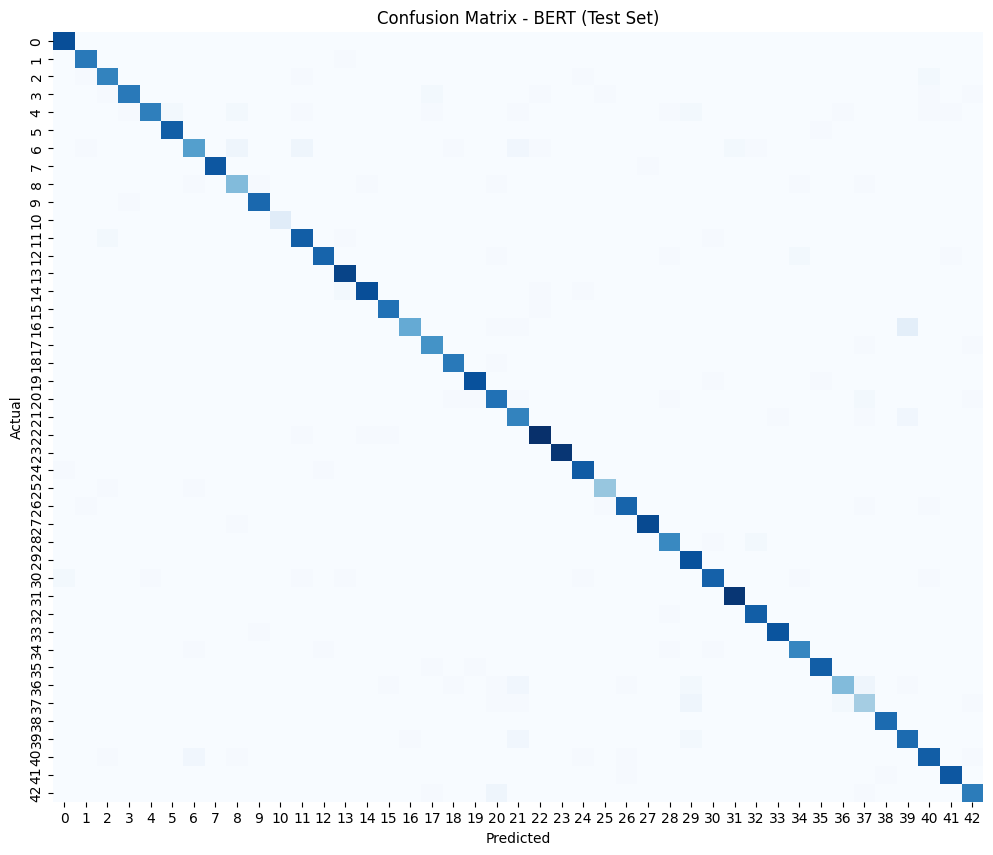

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on test set
bert_preds = trainer.predict(test_dataset)
y_true = bert_preds.label_ids
y_pred = bert_preds.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - BERT (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


Torch version: 2.5.1+cu121
CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_cosine_schedule_with_warmup
)

from tqdm import tqdm


In [2]:
df = pd.read_csv(r"C:\Users\jeead\Downloads\Preprocessed_Data.csv")

print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()


Shape: (13389, 2)
Columns: Index(['Category', 'Text'], dtype='object')


,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])

num_classes = len(label_encoder.classes_)

print("Number of classes:", num_classes)
df["label"].value_counts().head()


Number of classes: 43


label
22    410
23    384
31    384
14    368
40    364
Name: count, dtype: int64

In [4]:
# First split: 70% train, 30% temp
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Text"],
    df["label"],
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: 10% val, 20% test (from temp 30%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.6667,  # 20/30
    stratify=temp_labels,
    random_state=42
)

print("Train size:", len(train_texts))
print("Val size:", len(val_texts))
print("Test size:", len(test_texts))


Train size: 9372
Val size: 1338
Test size: 2679


In [5]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

MAX_LEN = 300  # Paper trained on first 300 words

def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

print("Tokenizer loaded.")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\jeead\Downloads\YKTmlL\envs\bert_resume\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jeead\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer loaded.


In [6]:
train_encodings = tokenize_texts(train_texts)
val_encodings   = tokenize_texts(val_texts)
test_encodings  = tokenize_texts(test_texts)

print("Train input shape:", train_encodings["input_ids"].shape)
print("Validation input shape:", val_encodings["input_ids"].shape)
print("Test input shape:", test_encodings["input_ids"].shape)


Train input shape: torch.Size([9372, 300])
Validation input shape: torch.Size([1338, 300])
Test input shape: torch.Size([2679, 300])


In [7]:
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = ResumeDataset(train_encodings, train_labels)
val_dataset   = ResumeDataset(val_encodings, val_labels)
test_dataset  = ResumeDataset(test_encodings, test_labels)

print("Datasets created.")


Datasets created.


In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights shape:", class_weights.shape)


Class weights shape: torch.Size([43])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=43
)

model.to(device)

print("Model loaded on:", device)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded on: cuda


In [10]:
BATCH_SIZE = 16  # Safe for RTX 4060 (8GB)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("DataLoaders ready.")


DataLoaders ready.


In [11]:
from torch.optim import AdamW

EPOCHS = 5
LR = 2e-5
WARMUP_RATIO = 0.1

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("Optimizer and scheduler ready.")


Optimizer and scheduler ready.


In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

print("Weighted loss ready.")


Weighted loss ready.


In [13]:
def train_one_epoch(model, loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader):
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


In [14]:
def evaluate(model, loader):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    
    return acc, weighted_f1, macro_f1


In [15]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, criterion)
    print(f"Train Loss: {train_loss:.4f}")
    
    val_acc, val_weighted_f1, val_macro_f1 = evaluate(model, val_loader)
    
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Weighted F1: {val_weighted_f1:.4f}")
    print(f"Validation Macro F1: {val_macro_f1:.4f}")



Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████| 586/586 [04:47<00:00,  2.04it/s]


Train Loss: 2.1757


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:12<00:00,  6.70it/s]


Validation Accuracy: 0.8468
Validation Weighted F1: 0.8389
Validation Macro F1: 0.8309

Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████| 586/586 [04:47<00:00,  2.04it/s]


Train Loss: 0.6842


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:12<00:00,  6.71it/s]


Validation Accuracy: 0.8812
Validation Weighted F1: 0.8803
Validation Macro F1: 0.8744

Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████| 586/586 [04:48<00:00,  2.03it/s]


Train Loss: 0.4891


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:12<00:00,  6.69it/s]


Validation Accuracy: 0.8939
Validation Weighted F1: 0.8939
Validation Macro F1: 0.8845

Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████| 586/586 [04:49<00:00,  2.02it/s]


Train Loss: 0.3668


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:12<00:00,  6.67it/s]


Validation Accuracy: 0.9028
Validation Weighted F1: 0.9029
Validation Macro F1: 0.8938

Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████| 586/586 [04:49<00:00,  2.03it/s]


Train Loss: 0.3152


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:12<00:00,  6.67it/s]

Validation Accuracy: 0.9051
Validation Weighted F1: 0.9046
Validation Macro F1: 0.8966


In [16]:
test_acc, test_weighted_f1, test_macro_f1 = evaluate(model, test_loader)

print("\n=== TEST RESULTS ===")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Weighted F1: {test_weighted_f1:.4f}")
print(f"Test Macro F1: {test_macro_f1:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:25<00:00,  6.66it/s]


=== TEST RESULTS ===
Test Accuracy: 0.8884
Test Weighted F1: 0.8870
Test Macro F1: 0.8814


In [17]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Re-tokenize (reuse MAX_LEN=300)
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=300,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(train_texts)
val_encodings   = tokenize_texts(val_texts)
test_encodings  = tokenize_texts(test_texts)

# Create datasets again
train_dataset = ResumeDataset(train_encodings, train_labels)
val_dataset   = ResumeDataset(val_encodings, val_labels)
test_dataset  = ResumeDataset(test_encodings, test_labels)

# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=43
)

model.to(device)

print("Fresh BERT loaded.")


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fresh BERT loaded.


In [18]:
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

EPOCHS = 4
LR = 1.5e-5
WARMUP_RATIO = 0.1

optimizer = AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=0.01
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

print("Optimizer + scheduler ready.")


Optimizer + scheduler ready.


In [20]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

print("New DataLoaders created.")


New DataLoaders created.
